In [1]:
# Importing the libraries needed

import numpy as np
import pandas as pd 
import seaborn as sb 
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams

from sklearn import preprocessing

In [2]:
# Importing all the modules from sklnearn to perform the analysis

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [3]:
# Setting plotting paramaters

%matplotlib inline  # It is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object
rcParams['figure.figsize'] = 5,4 #5" wide by 4" hight
sb.set_style('whitegrid')

UsageError: unrecognized arguments: # It is a magic function that renders the figure in a notebook (instead of displaying a dump of the figure object


In [4]:
# Downloading the dataset

df = pd.read_csv('titanic_data.csv')

## Exploratory Analysis of the dataset

In [5]:
print(df.info())
# There is 891 datapoints in the dataset with most values without missing values except for Age, Cabin and Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### Variable descriptions ###

* Survived: Survival (0 = No; 1 = Yes)
* Pclass: Passenger Class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Name: Name
* Sex: Sex
* Age: Age
* SibSp: Number of Siblings/Spouses Aboard
* Parch: Number of Parents/Children Aboard
* Ticket: Ticket Number
* Fare: Passenger Fare (British Pound)
* Cabin: Cabin
* Embarked: Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that my target variable is binary

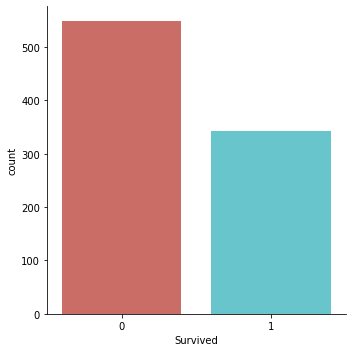

In [6]:
# Code from the original course: sb.countplot(x='Survived', data=df, palette='hls')
# I am using a more flexible code version I learned from DataCamp's "introduction to Visualization with Seaborn" course.

sb.catplot(data=df, x='Survived', kind='count', palette='hls')
plt.show()

### Checking for missing values

In [7]:
df.isnull().sum()
# There are 177 missing values in Age, 687 in Cabin and 2 in Embarked

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [8]:
df.describe()
# Displays the summary statistics of the variables

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values

**Dropping missing values**

So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:

* Survived: This variable is obviously relevant
* Pclass: Does a passenger's class on the boat affect their survivability?
* Sex: Could a passenger's gender impact their survival rate?
* SibSp: Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
* Parch: Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
* Fare: Does the fare a person paid effect his survivability? Maybe - let's keep it.
* Embarked: Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a person's name, ticket number, and passenger ID number? They're irrelevant for predicting survivability. Also, the cabin variable is almost all missing values, so we can drop all of these.

In [9]:
df2 = df.drop(columns = ['Name', 'Ticket', 'PassengerId', 'Cabin'])

In [10]:
df2.head()
# Displays the firt 5 rows of data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

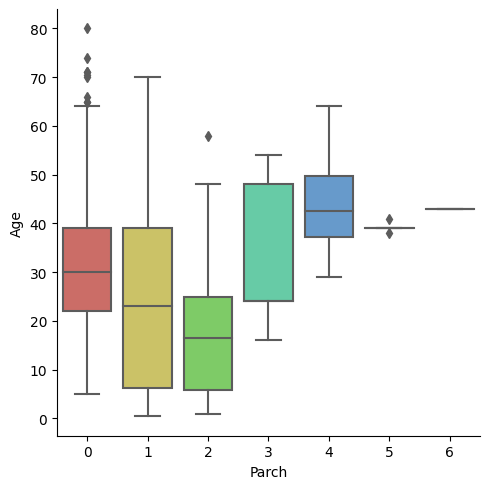

In [11]:
# Getting a quick overview of the distribution of data points for Parch vs Age.
# Simple code: sb.boxplot(x='Parch', y='Age', data=df2, palette='hls')

# Using DataCamp's taught code that provides more flexibility to play with the chart:

sb.catplot(data = df2, x = 'Parch', y = 'Age', kind ='box', palette = 'hls')
plt.show()

# The younger (Median = 20, green boxplot) the person  is the more likely they are to have at least 1 relatives on the boat (probably parents). The older the person (Median = 40, blue boxplot), the more likely that person will have 4 relatives on board (either parents or children).

The boxplot above helps us to identify we can probably fill the missing values for Age based on the number of relatives 'Parch' that person has.

### Let's figure out the average age per Parch group

In [12]:
Parch_groups = df2.groupby(['Parch']).mean()
Parch_groups

,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,
0,0.343658,2.321534,32.178503,0.237463,25.586774
1,0.550847,2.203390,24.422000,1.084746,46.778180
2,0.500000,2.275000,17.216912,2.062500,64.337604
3,0.600000,2.600000,33.200000,1.000000,25.951660
4,0.000000,2.500000,44.500000,0.750000,84.968750
5,0.200000,3.000000,39.200000,0.600000,32.550000
6,0.000000,3.000000,43.000000,1.000000,46.900000


In [13]:
# Writing a Function to iterate over the dataset and fill the missing values for Age based on the visual analysis above

def age_approx(cols):
    Age = cols[0]
    Parch = cols[1] # Created the 2 varialbes the funcion will iterate through

    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        elif Parch == 5:
            return 39
        elif Parch == 6:
            return 43
        else:
            return 30 # Average passenger age in the boat (all Parch groups included)
    else:
        return Age

In [14]:
# Applying the function created above to fill the null values of the Age variable

df2['Age'] = df2[['Age', 'Parch']].apply(age_approx, axis = 1) # axis = 1 (iterates over columns)
df2.isnull().sum()

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    2
dtype: int64

In [15]:
df2.dropna(inplace = True)
df2.reset_index(inplace= True, drop= True)

print(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  889 non-null    int64  
 1   Pclass    889 non-null    int64  
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Fare      889 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.7+ KB
None


### Converting categorical variables to dummy indicators (Binary Variables)

In [16]:
# This will transform the categorical variable Sex into a binary variable.
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
gender_cat = df2['Sex']
gender_encoded = label_encoder.fit_transform(gender_cat)
gender_encoded[0:5]

array([1, 0, 0, 0, 1])

In [17]:
df2.head()
# Comparing the output above with the table below we can see that 1 = male and 0 = female.

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Creating the binary variable male_gender based on the gender_encoded array

In [18]:
gender_df = pd.DataFrame(gender_encoded, columns=['male_gender'])
gender_df.head()

,male_gender
0,1
1,0
2,0
3,0
4,1


Let's repeat the process for the Embarked Variable to transform it into a numerical categorical variable

In [19]:
embarked_cat = df2['Embarked']
embarked_encoded= label_encoder.fit_transform(embarked_cat)
embarked_encoded[0:100]

array([2, 0, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 2,
       1, 2, 2, 2, 0, 2, 1, 2, 0, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 0,
       1, 2, 1, 1, 0, 2, 2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2, 2])

The embarked variable now became a multinomial categorical variable but we need it to be binary. Let's use a One-Hot encoder to create 3 separate columns for each of the categories within the embarked variable to get a binary response.

In [20]:
from sklearn.preprocessing import OneHotEncoder
binary_encoder = OneHotEncoder (categories= 'auto')
embarked_onehot= binary_encoder.fit_transform(embarked_encoded.reshape(-1,1)) #reshape method reshapes the variable into one single column. This will output a column array but we need it to be a matrix.
embarked_onehot_mtx= embarked_onehot.toarray()
embarked_df= pd.DataFrame(embarked_onehot_mtx, columns=['C', 'Q', 'S'])
embarked_df.head()

,C,Q,S
0,0.0,0.0,1.0
1,1.0,0.0,0.0
2,0.0,0.0,1.0
3,0.0,0.0,1.0
4,0.0,0.0,1.0


### Dropping the variables Sex and Embarked from the df2 and replace with the ones we just created

In [21]:
df2.drop(['Sex', 'Embarked'], axis = 1, inplace = True)
df2.head()

,Survived,Pclass,Age,SibSp,Parch,Fare
0,0,3,22.0,1,0,7.2500
1,1,1,38.0,1,0,71.2833
2,1,3,26.0,0,0,7.9250
3,1,1,35.0,1,0,53.1000
4,0,3,35.0,0,0,8.0500


### Concatenating the dataframes df2, gender_df and embarked_df

In [22]:
df3 = pd.concat([df2, gender_df, embarked_df], axis= 1, verify_integrity= True).astype(float)
df3.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male_gender,C,Q,S
0,0.0,3.0,22.0,1.0,0.0,7.2500,1.0,0.0,0.0,1.0
1,1.0,1.0,38.0,1.0,0.0,71.2833,0.0,1.0,0.0,0.0
2,1.0,3.0,26.0,0.0,0.0,7.9250,0.0,0.0,0.0,1.0
3,1.0,1.0,35.0,1.0,0.0,53.1000,0.0,0.0,0.0,1.0
4,0.0,3.0,35.0,0.0,0.0,8.0500,1.0,0.0,0.0,1.0


### Checking for independence between features

<AxesSubplot:>

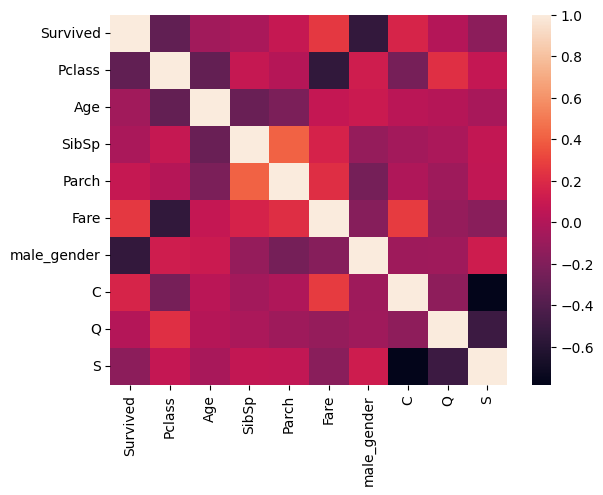

In [23]:
sb.heatmap(df3.corr())
# The darker the values the more correlated they are

We need to drop Fare and Pclass as they are dependent to each other

In [24]:
df3.drop(['Fare', 'Pclass'], axis = 1, inplace = True)
df3.head()

,Survived,Age,SibSp,Parch,male_gender,C,Q,S
0,0.0,22.0,1.0,0.0,1.0,0.0,0.0,1.0
1,1.0,38.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1.0,26.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,35.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.0,35.0,0.0,0.0,1.0,0.0,0.0,1.0


### Checking that our dataset size is sufficient

**Rule of thumb:** We need at least **50 records** per predictive feature

In [25]:
df3.info()

# We have 889 records per predictive feature so we have enough data to do a logistic regression

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     889 non-null    float64
 1   Age          889 non-null    float64
 2   SibSp        889 non-null    float64
 3   Parch        889 non-null    float64
 4   male_gender  889 non-null    float64
 5   C            889 non-null    float64
 6   Q            889 non-null    float64
 7   S            889 non-null    float64
dtypes: float64(8)
memory usage: 55.7 KB


### Breaking the data into train and test sets

In [26]:
x_train, x_test, y_train, y_test = train_test_split(df3.drop('Survived', axis = 1), # Dropped survived as it is what we are predicting for, we only want the x variables here.
                                                    df3['Survived'], test_size= 0.20, # Indicating to the model which variable is our target variable y.
                                                    random_state= 200)

Looking at the shape of the train datasets

In [27]:
print(x_train.shape)
print(y_train.shape)

(711, 7)
(711,)


In [28]:
x_train.head()

,Age,SibSp,Parch,male_gender,C,Q,S
719,6.0,0.0,1.0,0.0,0.0,0.0,1.0
165,24.0,0.0,1.0,0.0,0.0,0.0,1.0
879,33.0,0.0,0.0,1.0,0.0,0.0,1.0
451,30.0,0.0,0.0,1.0,1.0,0.0,0.0
181,9.0,4.0,2.0,1.0,0.0,0.0,1.0


### Deploying and evaluating the model

In [29]:
LogReg= LogisticRegression(solver= 'liblinear')
LogReg.fit(x_train, y_train)

LogisticRegression(solver='liblinear')

In [30]:
y_pred= LogReg.predict(x_test) 
# this line of code creates a prediction that will use to evaluate the model in the next step

### Model Evaluation

Classification report without cross-validation

In [31]:
print(classification_report(y_test, y_pred))
#precision and recall are around 81% which is not bad

              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85       109
         1.0       0.79      0.71      0.75        69

    accuracy                           0.81       178
   macro avg       0.81      0.80      0.80       178
weighted avg       0.81      0.81      0.81       178



k-fold cross-validation & confusion matrices

In [32]:
y_train_pred= cross_val_predict(LogReg, x_train, y_train, cv=5)
confusion_matrix(y_train, y_train_pred)

# According to the confusion matrix below, 379 and 180 are the number of correct predictions. 91 and 61 are the number of incorrect predictions

array([[379,  61],
       [ 91, 180]])

In [33]:
precision_score(y_train, y_train_pred)
# The models was 74.67 % precise.

0.7468879668049793

### Making a test prediction

Grabbing a row from the data set

In [34]:
df3[863:864]

,Survived,Age,SibSp,Parch,male_gender,C,Q,S
863,1.0,42.0,0.0,0.0,0.0,0.0,0.0,1.0


Creating the predictions with the respective probabilities

In [35]:
test_passenger= np.array([40, 0, 0, 0, 0, 0, 1]).reshape(1,-1)
# Created an array with slightly changed passenger's age.
print(LogReg.predict(test_passenger))
print(LogReg.predict_proba(test_passenger))


[1.]
[[0.26988808 0.73011192]]


/home/paulorob/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/paulorob/.local/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


**As seen above, the probability of the model prediction to be correct is of 73%**